# Heat Map Examples

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
DIR = "/workspace/nflbigdatabowl2023"
sys.path.append(DIR)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from shapely import Point as ShapelyPoint
from shapely import Polygon as ShapelyPolygon
from matplotlib.patches import Polygon as PolygonPatch

from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
import time
from contextlib import contextmanager


@contextmanager
def timer():
    """Helper function to time code within a context block."""
    start_time = time.perf_counter()
    yield
    duration = time.perf_counter() - start_time
    print(f"Ran in {duration:0.1f} secs")

In [5]:
def vertices_from_shape(shape):
    return list(shape.exterior.coords)


def vertices_to_shape(vertices):
    return ShapelyPolygon(vertices)


vec_vertices_to_shape = np.vectorize(vertices_to_shape)

In [152]:
example_shapes = [
    ShapelyPolygon([(0, 0), (0, 1), (1, 1), (1, 0)]),
    ShapelyPolygon([(0, 0), (0, 2), (2, 2), (2, 0)]),
    # ShapelyPolygon([(0, 1), (0, 2), (1, 2), (1, 1)]),
    ShapelyPolygon([(1, 1), (2, 1), (2, 2), (1, 2)]),
]

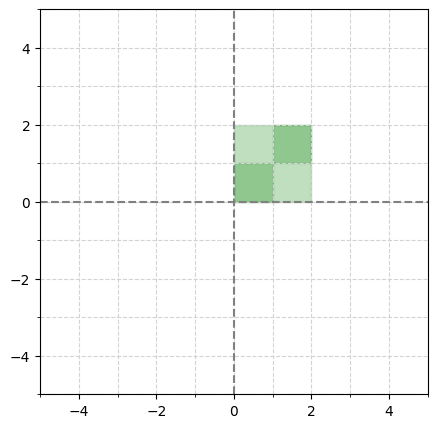

In [153]:
fig, ax = plt.subplots(1, 1)

for shape in example_shapes:
    vertices = vertices_from_shape(shape)
    patch = PolygonPatch(vertices, color="green", alpha=0.25)
    ax.add_patch(patch)
    
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.axhline(0, linestyle="--", color="gray")
ax.axvline(0, linestyle="--", color="gray")
ax.grid(which="both", linestyle="--", color="lightgray")
fig.set_size_inches(5, 5)
plt.show()

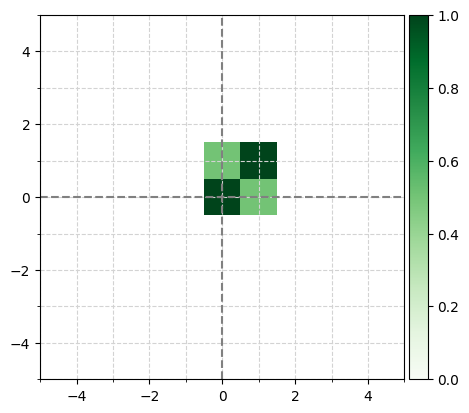

In [154]:
"""
[
     # each column has the same x coord
    [(x=0, y=0), (x=1, y=0)], # each row has the same y coord
    [(x=0, y=1), (x=1, y=1)],
]
"""

heatmap = [
    [1.0, 0.5],
    [0.5, 1.0],
]

fig, ax = plt.subplots(1, 1)

im = ax.imshow(heatmap, cmap="Greens", vmin=0, vmax=1)

# Colorbar on ax code based on : https://stackoverflow.com/a/49037495
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax, orientation="vertical")

ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.axhline(0, linestyle="--", color="gray")
ax.axvline(0, linestyle="--", color="gray")
ax.grid(which="both", linestyle="--", color="lightgray")
fig.set_size_inches(5, 5)
plt.show()

In [170]:
def heatmap_from_points(points, total, x_bins, y_bins):
    x = [p[0] for p in points]
    y = [p[1] for p in points]
    
    print(x_bins)
    print(y_bins)

    # Heatmap binning logic based on: https://stackoverflow.com/a/61632120
    heatmap, x_edges, y_edges = np.histogram2d(
        # Numpy uses the first dimension of the returned matrix for x and
        # the second dimension for y, but plotting this with imshow will
        # show a rotated image, so it is easier to swap the coordinates
        # before computing the Numpy histogram.
        x=y,
        y=x,
        bins=[x_bins, y_bins],
        # Actually we need to use bin_count / play_count, which
        # would be shape count in this case. So turn density off.
        # Density = bin_count / total_count / bin_area
        # Should we divide by bin area? If the results look wrong,
        # then we can just do bin_count / total_count ourselves.
        # density=True,
    )

    extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]
    
    # Reduce the heatmap values to the range [0, 1] by dividing by
    # the total number of observations the points were sampled from.
    # Note: This is not the total number of points.
    print(heatmap)
    scaled_heatmap = heatmap / total
    
    return scaled_heatmap, extent

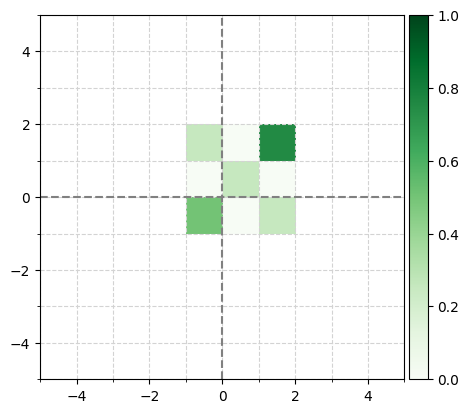

In [156]:
fig, ax = plt.subplots(1, 1)

data = [
    # Format: (x, y)
    (-1, -1),
    (-1, -1),
    (1, -1),
    (-1, 1),
    (1, 1),
    (1, 1),
    (1, 1),
    (0.5, 0.5),
]
bins = np.arange(-1, 3, 1)
heatmap, extent = heatmap_from_points(
    data,
    total=4,
    x_bins=bins,
    y_bins=bins
)

im = ax.imshow(heatmap, extent=extent, cmap="Greens", vmin=0, vmax=1, origin="lower")

# Colorbar on ax code based on : https://stackoverflow.com/a/49037495
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax, orientation="vertical")

ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.axhline(0, linestyle="--", color="gray")
ax.axvline(0, linestyle="--", color="gray")
ax.grid(which="both", linestyle="--", color="lightgray")
fig.set_size_inches(5, 5)
plt.show()

In [157]:
def sample_points_in_shapes(shapes, x_bins, y_bins, bin_size):
    half_bin = bin_size / 2.0
    points_in_pocket = []
    # This triple for-loop is inefficient, optimize with vector operations.
    for x in x_bins:
        for y in y_bins:
            # Sample point should be in the midpoint of the cell.
            sample_point = (x + half_bin, y + half_bin)
            # Display point for heatmap should be on the cell edge.
            display_point = (x, y)
            # Convert sample point to a shapely point to compare to polygon.
            shape_point = ShapelyPoint(*sample_point)
            for shape in shapes:
                # Also use the exterior so that both points inside the shape
                # use on the border are considered inside the shape.
                is_in_cell = shape.contains(shape_point) or shape.exterior.contains(shape_point)
                # Check the sample point, but save the display point.
                if is_in_cell:
                    points_in_pocket.append(display_point)
    return points_in_pocket

In [161]:
def get_heatmap_from_pocket_shapes(pocket_shapes, x_range, y_range, bin_size):
    x_min, x_max = x_range
    y_min, y_max = y_range
    x_bins = np.arange(x_min, x_max + bin_size, bin_size)
    y_bins = np.arange(y_min, y_max + bin_size, bin_size)
    points_in_pocket = sample_points_in_shapes(
        pocket_shapes,
        x_bins,
        y_bins,
        bin_size,
    )
    print(points_in_pocket)
    total = len(pocket_shapes)
    heatmap, extent = heatmap_from_points(
        points_in_pocket,
        total,
        x_bins,
        y_bins,
    )
    return heatmap, extent, bin_size

[(0.0, 0.0), (0.0, 0.0), (0.0, 0.5), (0.0, 0.5), (0.0, 1.0), (0.0, 1.5), (0.5, 0.0), (0.5, 0.0), (0.5, 0.5), (0.5, 0.5), (0.5, 1.0), (0.5, 1.5), (1.0, 0.0), (1.0, 0.5), (1.0, 1.0), (1.0, 1.0), (1.0, 1.5), (1.0, 1.5), (1.5, 0.0), (1.5, 0.5), (1.5, 1.0), (1.5, 1.0), (1.5, 1.5), (1.5, 1.5)]
[0.  0.5 1.  1.5 2. ]
[0.  0.5 1.  1.5]
[[2. 2. 1. 1.]
 [2. 2. 1. 1.]
 [2. 2. 4. 4.]]


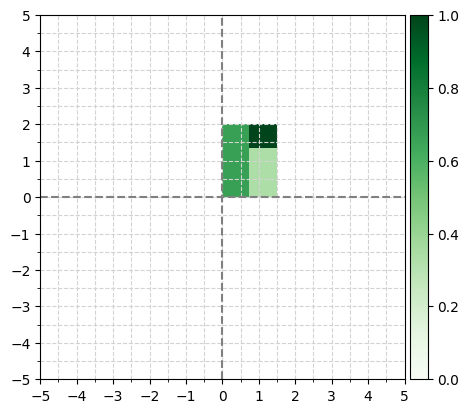

In [171]:
fig, ax = plt.subplots(1, 1)

heatmap, extent, bin_size = get_heatmap_from_pocket_shapes(
    example_shapes,
    x_range=(0, 2),
    y_range=(0, 1.5),
    bin_size=0.5,
)

im = ax.imshow(
    heatmap,
    extent=extent,
    cmap="Greens",
    vmin=0,
    vmax=1,
    origin="lower"
)

# Colorbar on ax code based on : https://stackoverflow.com/a/49037495
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax, orientation="vertical")

ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.xaxis.set_major_locator(MultipleLocator(2 * bin_size))
ax.yaxis.set_major_locator(MultipleLocator(2 * bin_size))
ax.xaxis.set_minor_locator(MultipleLocator(bin_size))
ax.yaxis.set_minor_locator(MultipleLocator(bin_size))
ax.axhline(0, linestyle="--", color="gray")
ax.axvline(0, linestyle="--", color="gray")
ax.grid(which="both", linestyle="--", color="lightgray")
fig.set_size_inches(5, 5)
plt.show()

In [166]:
vals = [(0.0, 0.0), (0.0, 0.0), (0.0, 0.5), (0.0, 0.5), (0.0, 1.0), (0.0, 1.5), (0.5, 0.0), (0.5, 0.0), (0.5, 0.5), (0.5, 0.5), (0.5, 1.0), (0.5, 1.5), (1.0, 0.0), (1.0, 0.5), (1.0, 1.0), (1.0, 1.0), (1.0, 1.5), (1.0, 1.5), (1.5, 0.0), (1.5, 0.5), (1.5, 1.0), (1.5, 1.0), (1.5, 1.5), (1.5, 1.5)]
c = {}
for t in vals:
    if t not in c:
        c[t] = 0
    c[t] += 1

In [167]:
c

{(0.0, 0.0): 2,
 (0.0, 0.5): 2,
 (0.0, 1.0): 1,
 (0.0, 1.5): 1,
 (0.5, 0.0): 2,
 (0.5, 0.5): 2,
 (0.5, 1.0): 1,
 (0.5, 1.5): 1,
 (1.0, 0.0): 1,
 (1.0, 0.5): 1,
 (1.0, 1.0): 2,
 (1.0, 1.5): 2,
 (1.5, 0.0): 1,
 (1.5, 0.5): 1,
 (1.5, 1.0): 2,
 (1.5, 1.5): 2}

In [163]:
heatmap

array([[0.66666667, 0.66666667, 0.66666667],
       [0.66666667, 0.66666667, 0.66666667],
       [0.33333333, 0.33333333, 1.33333333],
       [0.33333333, 0.33333333, 1.33333333]])

In [182]:
h, ex, ey = np.histogram2d(x=[0.5, 0.5], y=[0.5, 1.5], bins=[np.arange(0, 3, 1), np.arange(0, 2, 1)])

In [183]:
h

array([[1.],
       [0.]])

In [85]:
from ast import literal_eval


df_plays = pd.read_csv(f"{DIR}/data/raw/plays.csv")
df_play_metrics = pd.read_csv(f"{DIR}/data/outputs/play_metrics.csv")
df_areas = pd.read_csv(f"{DIR}/data/outputs/pocket_areas.csv")
df_areas["pocket"] = df_areas["pocket"].apply(literal_eval)

In [86]:
def get_play_pocket(df_play_metrics, df_areas, df_plays):
    """
    Choose one frame per play and area method and get
    the pocket object for that frame.
    """
    # Find the frame X seconds before the pocket ends.
    frames_per_second = 10
    df = pd.DataFrame(df_play_metrics)
    df = df[df["window_type"] == "before_end"]
    df["pocket_frame"] = (frames_per_second * df["time_start"]).astype(int)
    
    # Restrict the left side to one row per play, then
    # explode it with the right to get one row per play
    # and area type.
    left_cols = [
        "gameId",
        "playId",
        "pocket_frame",
        "frame_start",
        "frame_end",
    ]
    df = df[left_cols].drop_duplicates()

    # Extract vertices from pocket object, if any.
    def get_vertices(pocket):
        return pocket.get("metadata", {}).get("vertices")

    pocket_cols = [
        "gameId",
        "playId",
        "frameId",
        "method",
        "pocket",
    ]
    df_vertices = pd.DataFrame(df_areas[pocket_cols])
    vec_vertices = np.vectorize(get_vertices)
    df_vertices["vertices"] = vec_vertices(df_vertices["pocket"])
    df_vertices.drop(columns=["pocket"], inplace=True)
    
    # Drop plays without a polygon-shaped pocket.
    df_vertices = df_vertices[df_vertices["vertices"].notna()]

    # Inner join to keep only plays that have a window before
    # the pocket ends (left side) AND have a polygon-shaped
    # pocket (right side).
    df_pocket = df.merge(
        df_vertices,
        left_on=["gameId", "playId", "pocket_frame"],
        right_on=["gameId", "playId", "frameId"],
        how="inner",
    )
    df_pocket.drop(columns=["pocket_frame"], inplace=True)
    
    # Left join to plays to get metadata for these plays.
    df_out = df_pocket.merge(
        df_plays,
        on=["gameId", "playId"],
        how="left",
    )
    
    return df_out

In [87]:
show_cols = [
    "gameId",
    "playId",
    "frameId",
    "method",
    "vertices",
    "possessionTeam",
    "down",
]
df_pocket = get_play_pocket(df_play_metrics, df_areas, df_plays)
df_pocket[show_cols].head(10)

,gameId,playId,frameId,method,vertices,possessionTeam,down
0,2021090900,97,18,blocker_convex_hull,"[(-3.879999999999999, -3.1000000000000014), (-...",TB,3
1,2021090900,97,18,rushers_pocket_area,"[(-6.329999999999998, -2.1500000000000057), (-...",TB,3
2,2021090900,97,18,voronoi_pocket_area,"[(0.09839648090245734, -3.5495731919154774), (...",TB,3
3,2021090900,97,18,voronoi_rushers_only,"[(-0.7538752732534832, -3.145187813664214), (-...",TB,3
4,2021090900,97,18,adaptive_pocket_area,"[(-3.879999999999999, -3.1000000000000014), (-...",TB,3
5,2021090900,137,12,blocker_convex_hull,"[(-3.41, -1.8200000000000074), (-0.28999999999...",DAL,1
6,2021090900,137,12,rushers_pocket_area,"[(4.100000000000001, -0.38000000000000966), (-...",DAL,1
7,2021090900,137,12,voronoi_pocket_area,"[(-0.8616892212214013, -3.750377968366169), (-...",DAL,1
8,2021090900,137,12,voronoi_rushers_only,"[(-0.433970157080539, -2.7871829189807733), (3...",DAL,1
9,2021090900,137,12,adaptive_pocket_area,"[(-3.41, -1.8200000000000074), (-0.28999999999...",DAL,1


In [88]:
def get_pocket_shapes_for_area(df_pocket, default_area):
    df_pocket_default = df_pocket[df_pocket["method"] == default_area]
    pocket_shapes = vec_vertices_to_shape(df_pocket_default["vertices"])
    return pocket_shapes

In [129]:
pocket_shapes = get_pocket_shapes_for_area(df_pocket, "adaptive_pocket_area")[0:1]

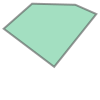

In [130]:
pocket_shapes[0]

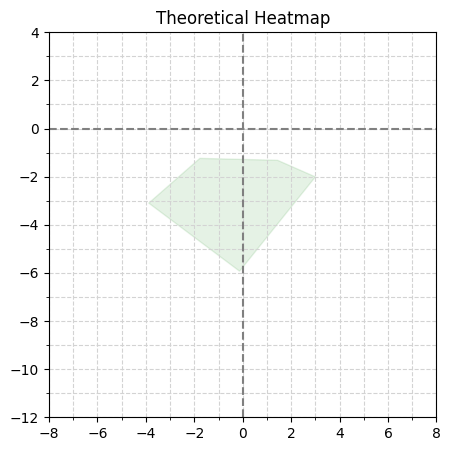

In [131]:
fig, ax = plt.subplots(1, 1)

alpha = 0.1
for shape in pocket_shapes:
    vertices = vertices_from_shape(shape)
    patch = PolygonPatch(vertices, color="green", alpha=alpha)
    ax.add_patch(patch)

ax.set_title("Theoretical Heatmap")
ax.set_xlim(-8, 8)
ax.set_ylim(-12, 4)
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.axhline(0, linestyle="--", color="gray")
ax.axvline(0, linestyle="--", color="gray")
ax.grid(which="both", linestyle="--", color="lightgray")
fig.set_size_inches(5, 5)
plt.show()

In [144]:
with timer():
    heatmap, extent, bin_size = get_heatmap_from_pocket_shapes(
        pocket_shapes,
        x_range=(-4, 4),
        y_range=(-4, 2),
        bin_size=1,
    )

Ran in 0.0 secs


In [145]:
heatmap.shape

(8, 6)

In [146]:
heatmap

array([[0., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 2.],
       [0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

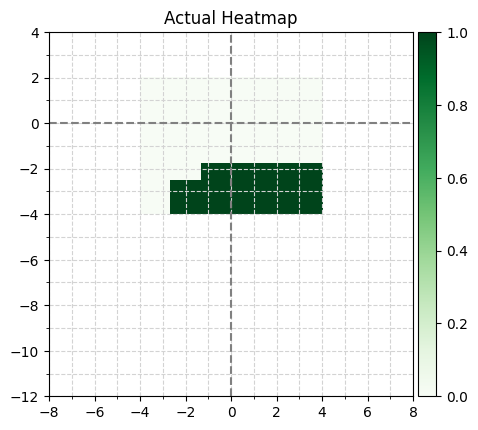

In [147]:
fig, ax = plt.subplots(1, 1)

im = ax.imshow(
    heatmap,
    extent=extent,
    cmap="Greens",
    vmin=0,
    vmax=1,
    origin="lower"
)

# Colorbar on ax code based on : https://stackoverflow.com/a/49037495
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax, orientation="vertical")

ax.set_title("Actual Heatmap")
ax.set_xlim(-8, 8)
ax.set_ylim(-12, 4)
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.axhline(0, linestyle="--", color="gray")
ax.axvline(0, linestyle="--", color="gray")
ax.grid(which="both", linestyle="--", color="lightgray")
fig.set_size_inches(5, 5)
plt.show()

In [ ]:
def make_shapely_point(x, y):
    return ShapelyPoint(x, y)


def check_contains_point(shape, point):
    return (
        shape.contains(point)
        or shape.exterior.contains(point)
    )


vec_make_shapely_point = np.vectorize(make_shapely_point)
vec_check_contains_point = np.vectorize(check_contains_point)


def sample_points_in_shapes_vectorized(shapes, bin_start, bin_end, bin_size):
    # Create bins. TODO: Allow different range for each axis.
    sample_range = np.arange(bin_start, bin_end + bin_size, bin_size)
    
    # Cross join to generate matrix of coordinates.
    df = pd.DataFrame({"i": sample_range})
    df = df.merge(df, how="cross").rename(columns={"i_x": "x", "i_y": "y"})
    
    # Add columns needed for sampling.
    half_bin = bin_size / 2.0
    df["x_mid"] = df["x"] + half_bin
    df["y_mid"] = df["y"] + half_bin
    # Sample point should be in the midpoint of the cell.
    # Display point for heatmap should be on the cell edge.
    # Convert sample point to a shapely point to compare to polygon.
    df["shapely_point"] = vec_make_shapely_point(df["x_mid"], df["y_mid"])
    
    # Join to shapes to filter to points inside the polygons.
    df_shapes = pd.DataFrame({"polygon": shapes})
    df_sample = df.merge(df_shapes, how="cross")
    
    # Check if point is in polygon.
    df_sample["contains_point"] = vec_check_contains_point(
        df_sample["polygon"],
        df_sample["shapely_point"]
    )
    
    # Return all the hits.
    # Each combination of sample point and pocket area where the point
    # is in the area is considered a hit.
    df_hits = df_sample[df_sample["contains_point"]]
    
    x = df_hits["x"].values
    y = df_hits["y"].values
    points = list(zip(x, y))
    return points

In [ ]:
def get_heatmap_from_pocket_shapes_vectorized(pocket_shapes, bin_start, bin_end, bin_size):
    points_in_pocket = sample_points_in_shapes_vectorized(
        pocket_shapes,
        bin_start,
        bin_end,
        bin_size,
    )
    total = len(pocket_shapes)
    heatmap, extent = heatmap_from_points(
        points_in_pocket,
        total,
        bin_start,
        bin_end,
        bin_size,
    )
    return heatmap, extent

In [ ]:
with timer():
    bin_size = 0.25
    heatmap, extent = get_heatmap_from_pocket_shapes_vectorized(
        pocket_shapes,
        bin_start=-10,
        bin_end=10,
        bin_size=bin_size,
    )

In [ ]:
fig, ax = plt.subplots(1, 1)

im = ax.imshow(
    heatmap,
    extent=extent,
    cmap="Greens",
    vmin=0,
    vmax=1,
    origin="lower"
)

# Colorbar on ax code based on : https://stackoverflow.com/a/49037495
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax, orientation="vertical")

ax.set_title("Actual Heatmap")
ax.set_xlim(-8, 8)
ax.set_ylim(-12, 4)
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.axhline(0, linestyle="--", color="gray")
ax.axvline(0, linestyle="--", color="gray")
ax.grid(which="both", linestyle="--", color="lightgray")
fig.set_size_inches(5, 5)
plt.show()